In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [81]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 model
model = YOLO("yolov8s.pt")


In [82]:
import os

root_dir = "D:\\pcb"  # Define root directory
dataset_dir = os.path.join(root_dir, "PCB_DATASET")  # Now this will work

for root, dirs, files in os.walk(dataset_dir):
    for name in dirs:
        print(os.path.join(root, name))


D:\pcb\PCB_DATASET\Annotations
D:\pcb\PCB_DATASET\images
D:\pcb\PCB_DATASET\images_resized
D:\pcb\PCB_DATASET\output
D:\pcb\PCB_DATASET\PCB_USED
D:\pcb\PCB_DATASET\rotation
D:\pcb\PCB_DATASET\Annotations\Missing_hole
D:\pcb\PCB_DATASET\Annotations\Mouse_bite
D:\pcb\PCB_DATASET\Annotations\Open_circuit
D:\pcb\PCB_DATASET\Annotations\Short
D:\pcb\PCB_DATASET\Annotations\Spur
D:\pcb\PCB_DATASET\Annotations\Spurious_copper
D:\pcb\PCB_DATASET\images\Missing_hole
D:\pcb\PCB_DATASET\images\Mouse_bite
D:\pcb\PCB_DATASET\images\Open_circuit
D:\pcb\PCB_DATASET\images\Short
D:\pcb\PCB_DATASET\images\Spur
D:\pcb\PCB_DATASET\images\Spurious_copper
D:\pcb\PCB_DATASET\output\3fold_crossval
D:\pcb\PCB_DATASET\output\images
D:\pcb\PCB_DATASET\output\labels
D:\pcb\PCB_DATASET\output\3fold_crossval\split_1
D:\pcb\PCB_DATASET\output\3fold_crossval\split_2
D:\pcb\PCB_DATASET\output\3fold_crossval\split_3
D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train
D:\pcb\PCB_DATASET\output\3fold_crossval\split_1

In [83]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [84]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [85]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [86]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [87]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_missing_hole_01.jpg,3034,1586,missing_hole,2459,1274,2530,1329
1,01_missing_hole_01.jpg,3034,1586,missing_hole,1613,334,1679,396
2,01_missing_hole_01.jpg,3034,1586,missing_hole,1726,794,1797,854
3,01_missing_hole_02.jpg,3034,1586,missing_hole,2584,232,2650,298
4,01_missing_hole_02.jpg,3034,1586,missing_hole,2366,803,2406,860


In [88]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'


In [89]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image

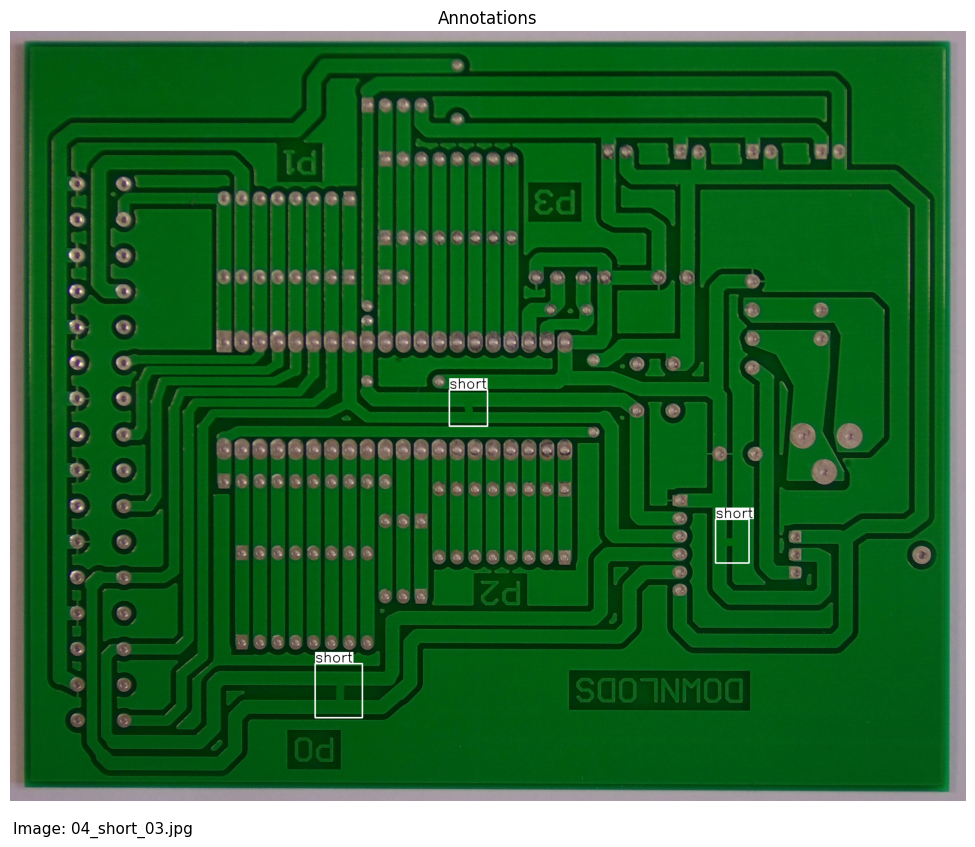

In [90]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [91]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [92]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_missing_hole_01.jpg,640,640,missing_hole,518,514,533,536
1,01_missing_hole_01.jpg,640,640,missing_hole,340,134,354,159
2,01_missing_hole_01.jpg,640,640,missing_hole,364,320,379,344
3,01_missing_hole_02.jpg,640,640,missing_hole,545,93,558,120
4,01_missing_hole_02.jpg,640,640,missing_hole,499,324,507,347


In [93]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [94]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

In [95]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

In [96]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels

In [97]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [98]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [99]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

C:\Users\aakas\AppData\Local\Temp\ipykernel_6708\2627102905.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


,0,1,2,3,4,5
01_missing_hole_01,21.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,15.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,21.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,18.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,24.0,0.0,0.0,0.0,0.0,0.0


In [100]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [101]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

C:\Users\aakas\AppData\Local\Temp\ipykernel_6708\3825890032.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
C:\Users\aakas\AppData\Local\Temp\ipykernel_6708\3825890032.p

In [102]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.461915,0.529963,0.637674,0.364921,0.479195,0.53702
split_2,0.618343,0.55545,0.426906,0.481281,0.501857,0.525862
split_3,0.432562,0.421488,0.452305,0.688432,0.519493,0.440874


In [103]:
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [105]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [106]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

In [107]:
import torch
torch.cuda.empty_cache()


In [108]:
print(torch.cuda.is_available())


True


In [35]:
# Start training
model.train(
    data="D:/pcb/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml",
    epochs=30,
    batch=2,  # Already reduced
    imgsz=512,  # Image size is fine
    device="cuda",  # Use GPU
    optimizer="Adam",
    lr0=0.001,
    half=True,  # FP16 for memory efficiency
)

Ultralytics 8.3.81  Python-3.11.0 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:/pcb/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=30, time=None, patience=100, batch=2, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\labels... 616 images, 0 backgrounds, 0 corrupt: 100%|██████████| 616/616 [00:02<00:00, 274.54it/s]

train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_01.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_03.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_05.jpg: 16 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_06.jpg: 12 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_07.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_08.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_hole_12.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\images\01_missing_h

train: New cache created: D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\train\labels.cache


val: Scanning D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\labels... 391 images, 0 backgrounds, 0 corrupt: 100%|██████████| 391/391 [00:01<00:00, 228.95it/s]

val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_02.jpg: 12 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_04.jpg: 15 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_09.jpg: 12 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_10.jpg: 15 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_11.jpg: 15 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_14.jpg: 12 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_15.jpg: 12 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\images\01_missing_hole_17.jpg: 15 duplicate labels 

val: New cache created: D:\pcb\PCB_DATASET\output\3fold_crossval\split_1\val\labels.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.752G      3.846      5.262      1.408          7        512: 100%|██████████| 308/308 [00:50<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:09<00:00, 10.44it/s]


                   all        391       1664      0.347     0.0662     0.0666      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.846G      3.181       3.72      1.179         17        512: 100%|██████████| 308/308 [00:42<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.56it/s]


                   all        391       1664      0.311      0.289      0.202     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.836G      2.897      3.202      1.113          9        512: 100%|██████████| 308/308 [00:42<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.52it/s]

                   all        391       1664      0.411      0.301      0.302      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      0.85G      2.782      2.841      1.099         13        512: 100%|██████████| 308/308 [00:42<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.56it/s]

                   all        391       1664      0.457      0.406      0.389      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.838G      2.683      2.644      1.074         18        512: 100%|██████████| 308/308 [00:42<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.92it/s]


                   all        391       1664      0.539      0.478      0.481      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      0.85G      2.631       2.54      1.065          8        512: 100%|██████████| 308/308 [00:41<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.33it/s]

                   all        391       1664       0.61      0.544      0.545      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.838G      2.637      2.414      1.056         16        512: 100%|██████████| 308/308 [00:41<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.51it/s]

                   all        391       1664      0.585      0.512      0.534      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.848G      2.522      2.196      1.037         13        512: 100%|██████████| 308/308 [00:41<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.80it/s]


                   all        391       1664      0.652      0.552      0.603      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.838G      2.413      2.125      1.005         16        512: 100%|██████████| 308/308 [00:42<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.55it/s]


                   all        391       1664      0.627      0.623      0.649      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      0.85G       2.42      2.068      1.007         10        512: 100%|██████████| 308/308 [00:42<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.95it/s]

                   all        391       1664      0.703      0.584      0.672      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.838G      2.382      1.995     0.9937         28        512: 100%|██████████| 308/308 [00:42<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.72it/s]


                   all        391       1664      0.747      0.645      0.725      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.848G      2.412      1.945      1.023          5        512: 100%|██████████| 308/308 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]

                   all        391       1664      0.756       0.64      0.708      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.836G      2.366      1.929       1.01          6        512: 100%|██████████| 308/308 [00:44<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:09<00:00, 10.42it/s]

                   all        391       1664       0.77      0.677      0.747      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.848G      2.341      1.842          1          7        512: 100%|██████████| 308/308 [00:47<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.84it/s]

                   all        391       1664      0.852      0.699      0.784      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.836G      2.261      1.765     0.9867         18        512: 100%|██████████| 308/308 [00:43<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.82it/s]

                   all        391       1664       0.84      0.684      0.778       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.848G      2.272      1.797     0.9832         14        512: 100%|██████████| 308/308 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.89it/s]


                   all        391       1664      0.838      0.716      0.778       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.838G      2.234      1.713     0.9793         19        512: 100%|██████████| 308/308 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.82it/s]

                   all        391       1664      0.851      0.765      0.818      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.848G       2.25      1.706      0.969          5        512: 100%|██████████| 308/308 [00:42<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.78it/s]

                   all        391       1664      0.867       0.75      0.819      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.838G      2.196      1.618     0.9705         13        512: 100%|██████████| 308/308 [00:41<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.68it/s]

                   all        391       1664      0.867      0.765      0.833      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.854G      2.211      1.583     0.9704          7        512: 100%|██████████| 308/308 [00:41<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.91it/s]

                   all        391       1664      0.907      0.742      0.838      0.368


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.844G      2.152      1.574     0.9794         10        512: 100%|██████████| 308/308 [00:42<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.87it/s]

                   all        391       1664      0.864      0.751      0.812      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.832G      2.121      1.479     0.9674          9        512: 100%|██████████| 308/308 [00:41<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.47it/s]


                   all        391       1664      0.897      0.768      0.835      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.844G       2.08      1.442     0.9663         10        512: 100%|██████████| 308/308 [00:41<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.89it/s]

                   all        391       1664      0.928      0.782       0.86      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.832G      2.085      1.468     0.9682          7        512: 100%|██████████| 308/308 [00:41<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.90it/s]

                   all        391       1664      0.927       0.79      0.873      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.844G       2.06       1.38     0.9614         10        512: 100%|██████████| 308/308 [00:41<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.89it/s]


                   all        391       1664      0.911      0.798      0.869       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.832G       2.05      1.334     0.9509          8        512: 100%|██████████| 308/308 [00:41<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.89it/s]

                   all        391       1664      0.891      0.804       0.86      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.844G      1.972      1.299     0.9477          6        512: 100%|██████████| 308/308 [00:41<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.64it/s]

                   all        391       1664      0.919      0.801      0.872      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.832G      2.003       1.29     0.9434         10        512: 100%|██████████| 308/308 [00:41<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.67it/s]

                   all        391       1664      0.923      0.804      0.875       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.844G       2.04      1.369     0.9491          8        512: 100%|██████████| 308/308 [00:41<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.81it/s]

                   all        391       1664       0.92      0.821      0.887      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.832G      1.967      1.257     0.9429          8        512: 100%|██████████| 308/308 [00:41<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:08<00:00, 11.86it/s]


                   all        391       1664      0.931      0.812      0.887      0.407

30 epochs completed in 0.446 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 22.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.81  Python-3.11.0 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 98/98 [00:07<00:00, 13.58it/s]


                   all        391       1664      0.931      0.812      0.887      0.407
          missing_hole         56        238      0.996      0.977      0.992      0.527
            mouse_bite         73        304      0.939      0.763      0.858      0.363
          open_circuit         60        250      0.932      0.748      0.848      0.361
                 short         65        281      0.932       0.94      0.956      0.414
                  spur         71        298      0.885      0.648      0.779      0.339
       spurious_copper         66        293        0.9      0.795      0.887      0.437
Speed: 0.7ms preprocess, 12.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D781036FD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [2]:
import os
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov8s.pt')

# Training parameters
batch = 2
project = 'pcb'
epochs = 30
imgsz = 512
save_period = 1
verbose = True
half=True
mixup = 0.3  # Blends two images and their labels, creating a composite image

# Fix path formatting for Windows
dataset_path = r"D:\pcb\PCB_DATASET\output"

# Create YAML configuration
all_data_yaml = f"""
path: {dataset_path}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

# Define the path to save data.yaml
data_path = os.path.join(dataset_path, 'data.yaml')

# Save the dataset configuration file
with open(data_path, 'w') as f:
    f.write(all_data_yaml)

# Train the YOLO model
result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project)


Ultralytics 8.3.81  Python-3.11.0 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:\pcb\PCB_DATASET\output\data.yaml, epochs=30, time=None, patience=100, batch=2, imgsz=512, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning D:\pcb\PCB_DATASET\output\labels\train.cache... 693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 693/693 [00:00<?, ?it/s]

train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_01.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_02.jpg: 12 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_03.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_04.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_05.jpg: 16 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_06.jpg: 12 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_07.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_08.jpg: 15 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\output\images\train\01_missing_hole_09.jpg: 12 duplicate labels removed
train: WARNING  D:\pcb\PCB_DATASET\ou


val: Scanning D:\pcb\PCB_DATASET\output\labels\val.cache... 183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<?, ?it/s]

val: WARNING  D:\pcb\PCB_DATASET\output\images\val\01_short_13.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\01_spur_17.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\01_spurious_copper_08.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\04_missing_hole_09.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\04_mouse_bite_09.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\04_open_circuit_01.jpg: 3 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\04_spurious_copper_09.jpg: 6 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\05_spurious_copper_02.jpg: 5 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\06_missing_hole_05.jpg: 5 duplicate labels removed
val: WARNING  D:\pcb\PCB_DATASET\output\images\val\06_spur_02.jpg: 5 duplicate labels remo

Plotting labels to pcb\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to pcb\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.758G      3.859      10.96      1.558          9        512: 100%|██████████| 347/347 [00:56<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00,  9.56it/s]


                   all        183        791      0.332     0.0968     0.0903      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.824G      3.076       3.59      1.183          6        512: 100%|██████████| 347/347 [00:47<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 10.34it/s]

                   all        183        791      0.306       0.33      0.285      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.854G      2.835      2.973      1.126          4        512: 100%|██████████| 347/347 [00:49<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.57it/s]

                   all        183        791      0.514      0.417      0.399      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.854G      2.746       2.68      1.083         11        512: 100%|██████████| 347/347 [00:48<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.46it/s]


                   all        183        791      0.553      0.538      0.549      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.842G      2.631      2.552      1.058          2        512: 100%|██████████| 347/347 [00:48<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.30it/s]

                   all        183        791      0.612      0.545      0.565      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.854G      2.611      2.324      1.057          5        512: 100%|██████████| 347/347 [00:47<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.06it/s]

                   all        183        791      0.717      0.573      0.651      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.842G        2.5      2.064       1.02          4        512: 100%|██████████| 347/347 [00:47<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.27it/s]


                   all        183        791      0.772      0.634      0.723       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.854G      2.454      2.034       1.02          5        512: 100%|██████████| 347/347 [00:49<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.70it/s]

                   all        183        791      0.741      0.578       0.67      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.842G      2.353      1.858      1.002          0        512: 100%|██████████| 347/347 [00:47<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.72it/s]

                   all        183        791      0.837      0.701      0.787      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.854G      2.321      1.818     0.9818          4        512: 100%|██████████| 347/347 [00:50<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.83it/s]

                   all        183        791      0.824      0.721      0.789      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.842G      2.338       1.78     0.9909         11        512: 100%|██████████| 347/347 [00:48<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.90it/s]

                   all        183        791      0.875      0.718      0.809      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.854G        2.3      1.774      0.984          0        512: 100%|██████████| 347/347 [00:49<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.70it/s]

                   all        183        791      0.855      0.739      0.823      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.842G      2.289      1.655     0.9831          1        512: 100%|██████████| 347/347 [00:51<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.18it/s]

                   all        183        791      0.899       0.78      0.856      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.854G      2.267      1.674     0.9735          8        512: 100%|██████████| 347/347 [00:48<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.31it/s]

                   all        183        791      0.871      0.751      0.836      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.842G      2.267      1.684     0.9757          4        512: 100%|██████████| 347/347 [00:49<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.63it/s]

                   all        183        791      0.855      0.773      0.837      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.854G      2.176      1.517     0.9593          0        512: 100%|██████████| 347/347 [00:49<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.80it/s]

                   all        183        791      0.873       0.74      0.835      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.842G       2.17      1.522     0.9651          3        512: 100%|██████████| 347/347 [00:49<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.83it/s]

                   all        183        791      0.896      0.794      0.875      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.844G      2.221      1.593     0.9652          3        512: 100%|██████████| 347/347 [00:48<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.21it/s]


                   all        183        791      0.883       0.78      0.859      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.854G       2.15      1.487     0.9657         16        512: 100%|██████████| 347/347 [00:48<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 10.87it/s]

                   all        183        791       0.92      0.801      0.887      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.852G      2.147      1.496     0.9595          8        512: 100%|██████████| 347/347 [00:47<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.79it/s]

                   all        183        791      0.919      0.817      0.894      0.442


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.842G      2.051      1.413     0.9635          4        512: 100%|██████████| 347/347 [00:49<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.59it/s]

                   all        183        791      0.903       0.81      0.878        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.854G      2.056      1.342     0.9514          5        512: 100%|██████████| 347/347 [00:48<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.56it/s]

                   all        183        791      0.923       0.83      0.905      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.842G      2.013      1.337     0.9585          3        512: 100%|██████████| 347/347 [00:48<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.63it/s]

                   all        183        791      0.953      0.821      0.906      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.854G      2.027      1.325     0.9496          5        512: 100%|██████████| 347/347 [00:48<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.15it/s]

                   all        183        791      0.912      0.831      0.905      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.842G       1.98      1.305     0.9464          3        512: 100%|██████████| 347/347 [00:48<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.17it/s]

                   all        183        791       0.94      0.832       0.91      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.854G      2.002      1.307     0.9532          3        512: 100%|██████████| 347/347 [00:48<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.26it/s]

                   all        183        791      0.939      0.838       0.92      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.842G      1.965      1.252     0.9467          5        512: 100%|██████████| 347/347 [00:48<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.46it/s]

                   all        183        791      0.937      0.849      0.918      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.854G      1.968      1.262     0.9394          3        512: 100%|██████████| 347/347 [00:49<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:04<00:00, 11.48it/s]

                   all        183        791      0.956      0.858      0.932      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.842G       1.91      1.154     0.9323          4        512: 100%|██████████| 347/347 [00:48<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.86it/s]


                   all        183        791      0.931      0.845      0.924      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.854G      1.898      1.187     0.9278          5        512: 100%|██████████| 347/347 [00:48<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 11.80it/s]

                   all        183        791       0.96      0.857       0.93      0.465



30 epochs completed in 0.464 hours.
Optimizer stripped from pcb\train2\weights\last.pt, 22.5MB
Optimizer stripped from pcb\train2\weights\best.pt, 22.5MB

Validating pcb\train2\weights\best.pt...
Ultralytics 8.3.81  Python-3.11.0 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:03<00:00, 12.46it/s]


                   all        183        791      0.959      0.857       0.93      0.466
          missing_hole         32        143      0.993      0.978      0.993      0.563
            mouse_bite         31        138      0.959       0.84      0.934      0.456
          open_circuit         33        143      0.984      0.863      0.943      0.444
                 short         28        115      0.886      0.957      0.943       0.46
                  spur         32        135          1      0.701      0.879      0.445
       spurious_copper         27        117      0.935      0.803      0.888      0.427
Speed: 0.8ms preprocess, 12.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to pcb\train2


In [109]:
import os
import shutil

root_dir=r"D:\pcb"
results_dir = 'pcb/train2'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'D:\\pcb\\results'

In [110]:
import os
import shutil
import pandas as pd  # Import pandas

# Ensure dest_results_dir is properly defined
root_dir = r'D:\pcb'  # Replace with the actual path
dest_results_dir = os.path.join(root_dir, 'results')

# Read and process the CSV file
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()  # Remove leading/trailing spaces in column names
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()  # Convert to numeric & drop NaN
print(results_df.head())  # Display first 5 rows


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   61.5489         3.85950        10.96170         1.55826   
1      2  115.5330         3.07642         3.58988         1.18288   
2      3  170.5790         2.83526         2.97313         1.12609   
3      4  224.1250         2.74620         2.67952         1.08293   
4      5  277.5920         2.63053         2.55226         1.05840   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.33188            0.09683           0.09027   
1               0.30585            0.33009           0.28550   
2               0.51359            0.41704           0.39917   
3               0.55297            0.53846           0.54894   
4               0.61170            0.54453           0.56536   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.02902       2.95206       4.12143       1.17340  0.000332   
1              0.09695       2.58017  

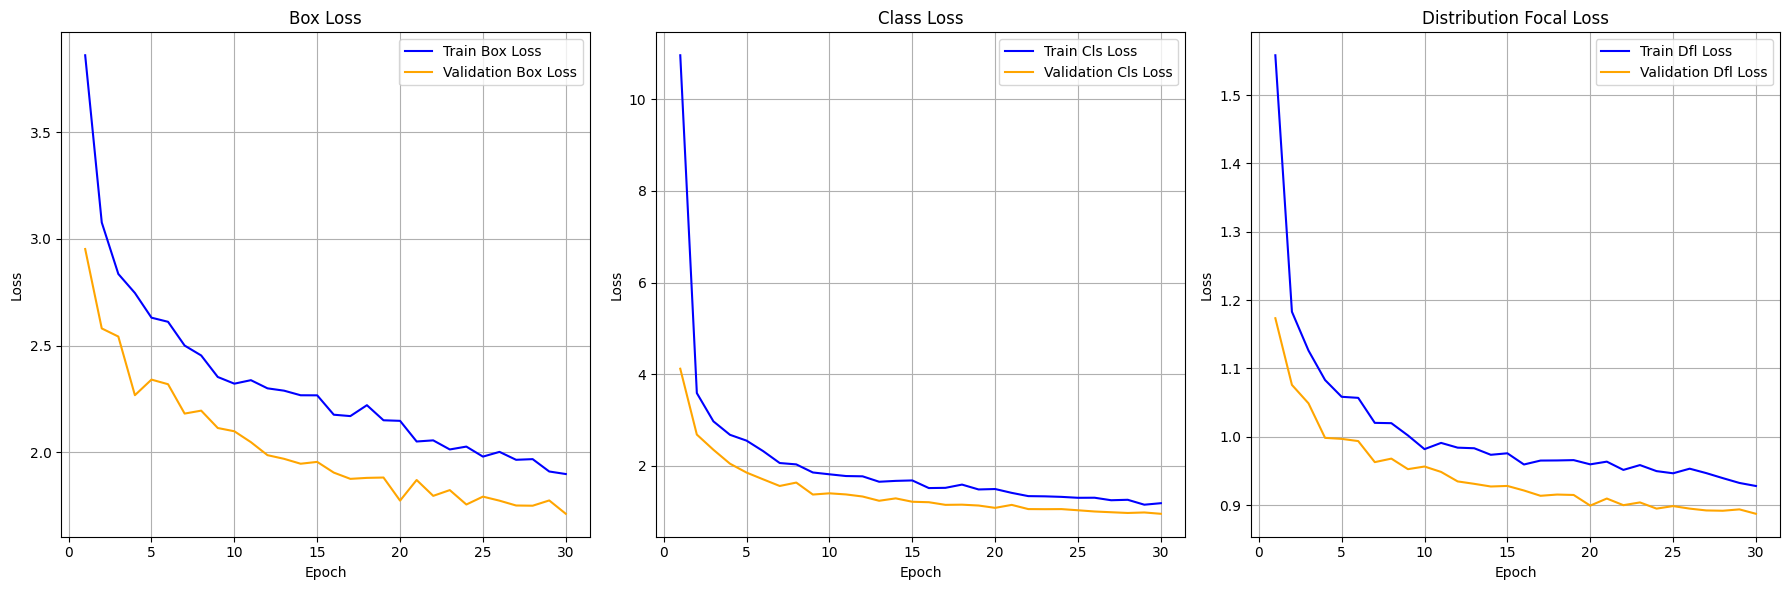

In [111]:
import pandas as pd
import matplotlib.pyplot as plt  # Import Matplotlib

# Extract loss values from the dataframe
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Box Loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Class Loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot Distribution Focal Loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [112]:
plt.show(block=True)


In [113]:
print(results_df.head())


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   61.5489         3.85950        10.96170         1.55826   
1      2  115.5330         3.07642         3.58988         1.18288   
2      3  170.5790         2.83526         2.97313         1.12609   
3      4  224.1250         2.74620         2.67952         1.08293   
4      5  277.5920         2.63053         2.55226         1.05840   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.33188            0.09683           0.09027   
1               0.30585            0.33009           0.28550   
2               0.51359            0.41704           0.39917   
3               0.55297            0.53846           0.54894   
4               0.61170            0.54453           0.56536   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.02902       2.95206       4.12143       1.17340  0.000332   
1              0.09695       2.58017  

In [115]:
print(len(epochs), len(train_box_loss), len(val_box_loss))  # Check if lists have values


30 30 30


In [143]:
import os
dest_results_dir =r"D:\pcb\results"
output_dir=r"D:\pcb\PCB_DATASET\output"
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_02.jpg: 640x640 3 missing_holes, 20.4ms
image 2/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_04.jpg: 640x640 2 missing_holes, 21.3ms
image 3/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_05.jpg: 640x640 3 missing_holes, 30.1ms
image 4/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_06.jpg: 640x640 3 missing_holes, 20.1ms
image 5/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_09.jpg: 640x640 3 missing_holes, 20.8ms
image 6/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_12.jpg: 640x640 3 missing_holes, 20.2ms
image 7/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_14.jpg: 640x640 2 missing_holes, 20.6ms
image 8/204 D:\pcb\PCB_DATASET\output\images\val\01_missing_hole_15.jpg: 640x640 3 missing_holes, 20.0ms
image 9/204 D:\pcb\PCB_DATASET\output\images\val\01_mouse_bite_04.jpg: 640x640 1 open_circuit, 36.8ms
image 10/204 D:\pcb\PCB_DATASET\output\images\val\01_mous

In [149]:
predict_dir = 'runs\detect\predict7'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'D:\\pcb\\results/predict'

In [150]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [151]:

file_path=r'D:\pcb\PCB_DATASET\output\3fold_crossval\split_3\train\labels\12_spurious_copper_10.txt'
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(file_path)
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.7125, 0.14921875, 0.021875, 0.0359375],
 [5.0, 0.56328125, 0.3796875, 0.0234375, 0.021875],
 [5.0, 0.73203125, 0.58671875, 0.0140625, 0.0359375],
 [5.0, 0.44375, 0.740625, 0.0375, 0.01875],
 [5.0, 0.13828125, 0.65390625, 0.0328125, 0.0203125],
 [5.0, 0.7125, 0.14921875, 0.021875, 0.0359375],
 [5.0, 0.56328125, 0.3796875, 0.0234375, 0.021875],
 [5.0, 0.73203125, 0.58671875, 0.0140625, 0.0359375],
 [5.0, 0.44375, 0.740625, 0.0375, 0.01875],
 [5.0, 0.13828125, 0.65390625, 0.0328125, 0.0203125],
 [5.0, 0.7125, 0.14921875, 0.021875, 0.0359375],
 [5.0, 0.56328125, 0.3796875, 0.0234375, 0.021875],
 [5.0, 0.73203125, 0.58671875, 0.0140625, 0.0359375],
 [5.0, 0.44375, 0.740625, 0.0375, 0.01875],
 [5.0, 0.13828125, 0.65390625, 0.0328125, 0.0203125],
 [5.0, 0.7125, 0.14921875, 0.021875, 0.0359375],
 [5.0, 0.56328125, 0.3796875, 0.0234375, 0.021875],
 [5.0, 0.73203125, 0.58671875, 0.0140625, 0.0359375],
 [5.0, 0.44375, 0.740625, 0.0375, 0.01875],
 [5.0, 0.13828125, 0.65390625, 0.0328125, 

In [152]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    # Your function logic here
    return converted_dataframe


In [153]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    """
    Converts YOLO format labels to original annotation format.
    """
    # Example logic (modify based on your actual needs)
    converted_data = []
    for label in yolo_labels:
        class_id, x_center, y_center, width, height = label
        class_name = classes[int(class_id)]  # Convert class ID to name
        converted_data.append([image_name, class_name, x_center, y_center, width, height])

    # Convert to DataFrame
    import pandas as pd
    converted_dataframe = pd.DataFrame(
        converted_data, columns=['image', 'class', 'x_center', 'y_center', 'width', 'height']
    )

    return converted_dataframe


In [154]:
pred_annot_df = yolo_to_original_annot('12_spurious_copper_10.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()


,image,class,x_center,y_center,width,height
0,12_spurious_copper_10.jpg,spurious_copper,0.712500,0.149219,0.021875,0.035937
1,12_spurious_copper_10.jpg,spurious_copper,0.563281,0.379688,0.023438,0.021875
2,12_spurious_copper_10.jpg,spurious_copper,0.732031,0.586719,0.014063,0.035937
3,12_spurious_copper_10.jpg,spurious_copper,0.443750,0.740625,0.037500,0.018750
4,12_spurious_copper_10.jpg,spurious_copper,0.138281,0.653906,0.032813,0.020313


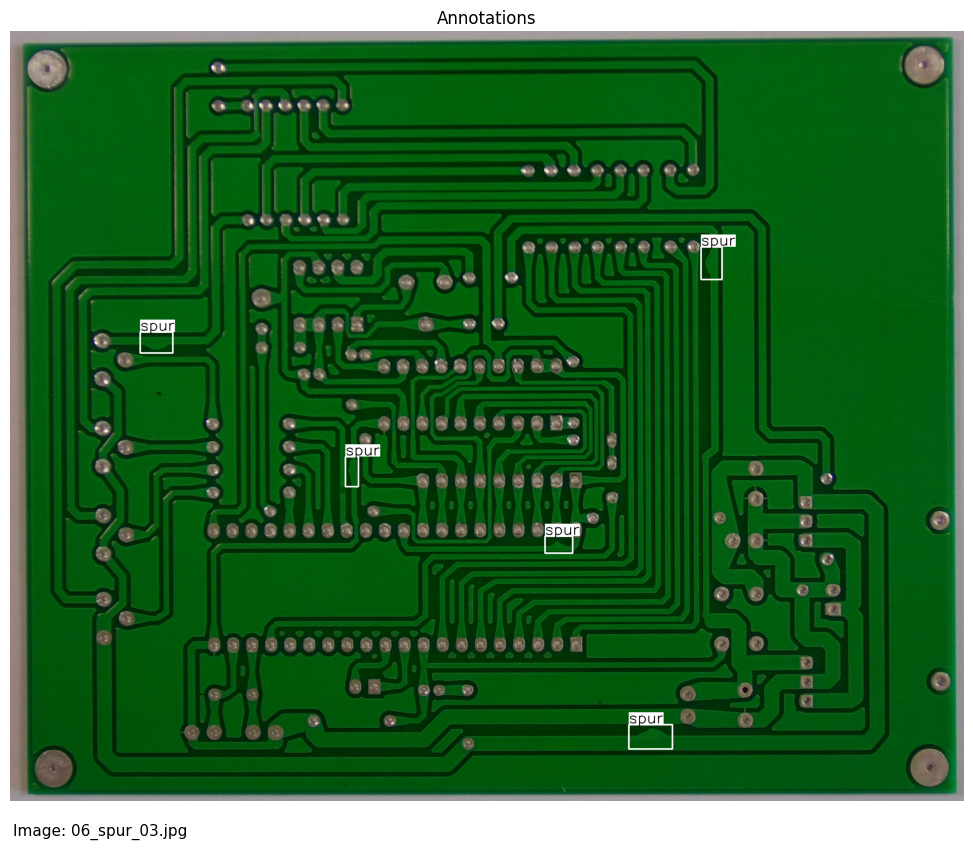

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

visualize_annotations('06_spur_03.jpg', images_dir, annot_df, is_subfolder=True);


In [156]:

model.export()

Ultralytics 8.3.81  Python-3.11.0 torch-2.6.0+cu118 CPU (11th Gen Intel Core(TM) i5-11300H 3.10GHz)

PyTorch: starting from 'D:\pcb\results\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 10, 5376) (21.5 MB)

TorchScript: starting export with torch 2.6.0+cu118...
TorchScript: export success  2.9s, saved as 'D:\pcb\results\weights\best.torchscript' (42.8 MB)

Export complete (8.3s)
Results saved to D:\pcb\results\weights
Predict:         yolo predict task=detect model=D:\pcb\results\weights\best.torchscript imgsz=512  
Validate:        yolo val task=detect model=D:\pcb\results\weights\best.torchscript imgsz=512 data=D:\pcb\PCB_DATASET\output\data.yaml  
Visualize:       https://netron.app


'D:\\pcb\\results\\weights\\best.torchscript'

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading D:\pcb\results\weights\best.torchscript for TorchScript inference...

0: 512x512 5 shorts, 108.7ms
Speed: 40.0ms preprocess, 108.7ms inference, 75.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict14
1 label saved to runs\detect\predict14\labels


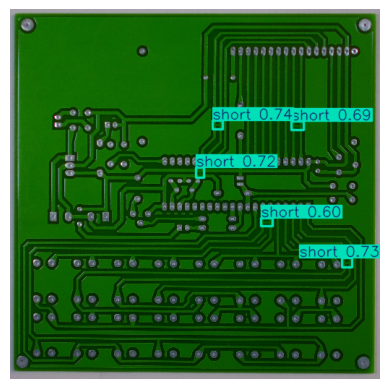

In [1]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the TorchScript model
model_path = 'D:\\pcb\\results\\weights\\best.torchscript'

model = YOLO(model_path)  # Load YOLO model

# Load and preprocess the image
image_path = r"D:\test\12_short_10.jpg"
image = cv2.imread(image_path)  # Read the image
image_resized = cv2.resize(image, (512, 512))  # Resize to match model input
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Run inference
results = model(image_rgb, imgsz=512, conf=0.25, save=True, save_txt=True, save_conf=True)

# Display results
result_img = results[0].plot()  # Draw detections on the image
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.show()


In [2]:
import joblib
from ultralytics import YOLO
model_path = 'D:\\pcb\\results\\weights\\best.torchscript'
model = YOLO(model_path)
joblib.dump(model,"model.pkl")
print("successfully")

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
successfully
